In [1]:
import contractions
import string
import re
import os
import glob
import pickle
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from datasets import load_dataset
from rouge import Rouge
import gensim.downloader as gensim_api
from collections import Counter
from matplotlib import pyplot as plt

from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Bidirectional

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize

### Read the saved tokenizer

In [2]:
import pickle
with open('article_tokenizer.pickle', 'rb') as handle:
    article_tokenizer = pickle.load(handle)

In [3]:
with open('summary_tokenizer.pickle', 'rb') as handle:
    summary_tokenizer = pickle.load(handle)

In [4]:
dataset = load_dataset('cnn_dailymail', '3.0.0')
data = dataset['test']
data_df = pd.DataFrame(data)

Found cached dataset cnn_dailymail (C:/Users/vijay/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de)


  0%|          | 0/3 [00:00<?, ?it/s]

### Preprocess test data

#### Preprocessing steps:
<ol>
<li>convert all characters in the text to lowercase</li>

**Example**: if the input text is "Hello World", it will be converted to "hello world".

<li>Remove all punctuation marks from the text using the translate method and maketrans function from the string module.</li>

**Example**: if the input text is "Hello, World!", it will be converted to "Hello World".

<li>Remove any non-alphanumeric characters from the text using regular expressions. It replaces any character that is not a word character (\w) or whitespace character (\s) with an empty string.</li> 

**Example**: if the input text is "Hello @world!", it will be converted to "Hello World".

<li>Tokenize the preprocessed text into individual words using the word_tokenize function from the NLTK library.</li> 

**Example**: if the input text is "Hello World", it will be tokenized into the list of tokens: ['Hello', 'World'].

<li>Remove stop words from the list of tokens. Stop words are commonly occurring words (e.g., "the", "is", "and") that do not carry much meaning in the context of natural language processing tasks.</li>

**Example**: if the input tokens are ['Hello', 'World', 'this', 'is', 'a'], and the stop words list contains ['this', 'is', 'a'], the resulting tokens will be ['Hello', 'World'].

<li> Lemmatize the tokens into their base forms using the WordNet lemmatizer from the NLTK library.</li>

**Example**: if the input words are "runs", "running", "ran", and "run", the resulting word will be "run".

<li>Expand contracted words in the text using the contractions library.</li>

**Example**: if the input preprocessed text is "I'm happy", it will be expanded to "I am happy".

In [5]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
def preprocess_text(text):

    text = text.lower()

    text = text.translate(str.maketrans("", "", string.punctuation))

    text = re.sub(r'\.(?=[^ \W\d])', '. ', str(text))

    text = re.sub(r"[^\w\s]", "", text)

    text = " ".join([single_word.strip() for single_word in text.split()])

    text = ''.join([char for char in text if char.isalpha() or char.isspace()])

    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token, wordnet.VERB) for token in tokens]

    preprocessed_text = ' '.join(tokens)

    preprocessed_text = contractions.fix(preprocessed_text)

    return preprocessed_text

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vijay\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vijay\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vijay\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
data_df['article'] = data_df['article'].apply(preprocess_text)
data_df['highlights'] = data_df['highlights'].apply(preprocess_text)

In [7]:
article_max_len = 500
summary_max_len = 50

### Load the vocabulary and the trained model

In [15]:
with open('article_vocabulary.json', 'r') as file:
    article_vocabulary = json.load(file)

In [16]:
with open('summary_vocabulary.json', 'r') as file:
    summary_vocabulary = json.load(file)

In [17]:
encoder_model = load_model('encoder_model.h5')
decoder_model = load_model('decoder_model.h5')

### Add padding token to the vocabulary

In [18]:
new_word = "<unknown>"
index = 0
summary_tokenizer.word_index[new_word] = index
summary_tokenizer.index_word[index] = new_word

### Define the inference function

In [19]:
def decode_sequence(input_seq):
    # Encode the input as state vectors
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1
    target_seq = np.zeros((1,1))

    # Populate the first word of target sequence with the start word
    target_seq[0, 0] = summary_tokenizer.word_index['<start>']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq, input_seq, e_out] + [e_h, e_c])

        # Sample a token
        final_prob_index = np.argmax(output_tokens[0, -1, :])

        # Distinguish between generated and copied words based on final_prob_index
        if final_prob_index < len(summary_vocabulary):
            # It's a generated word
            sampled_token = summary_tokenizer.index_word[final_prob_index]
        else:
            # It's a copied word
            copied_word_index = final_prob_index - len(summary_vocabulary)
            sampled_token = article_tokenizer.index_word[input_seq[0, copied_word_index]]

        if(sampled_token!='<end>'):
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find stop word
        if (sampled_token == '<end>' or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = summary_tokenizer.word_index[sampled_token] if sampled_token in summary_tokenizer.word_index else summary_tokenizer.word_index['<unknown>']

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [20]:
def get_summary(row):
    article = row['article']
    article = '<start> ' + article + ' <end>'
    sequence = article_tokenizer.texts_to_sequences([article])
    sequence_padded = pad_sequences(sequence, maxlen=article_max_len, padding='post')
    return decode_sequence(sequence_padded)

### Translate the test articles

In [21]:
# Define batch size
batch_size = 100

# Add a column to your DataFrame that indicates the batch number of each record
data_df['batch'] = np.arange(len(data_df)) // batch_size

# Process each batch
for batch_num, batch in data_df.groupby('batch'):
    print('batch: ', batch_num + 1)

    file_path = os.path.join("seq2seq_outputs", f"batch_{batch_num + 1}.csv.zip")
    if os.path.exists(file_path):
        print(f"The file '{file_path}' exists, skipping batch {batch_num + 1}.")
        continue
    else:
        print(f"The file '{file_path}' does not exist.")

    batch['summary'] = batch.apply(lambda row: get_summary(row), axis=1)

    # Save batch outputs to a zipped CSV file
    batch.to_csv(os.path.join("seq2seq_outputs", f"batch_{batch_num + 1}.csv.zip"), index=False, compression="zip")

batch:  1
The file 'seq2seq_outputs\batch_1.csv.zip' exists, skipping batch 1.
batch:  2
The file 'seq2seq_outputs\batch_2.csv.zip' exists, skipping batch 2.
batch:  3
The file 'seq2seq_outputs\batch_3.csv.zip' exists, skipping batch 3.
batch:  4
The file 'seq2seq_outputs\batch_4.csv.zip' exists, skipping batch 4.
batch:  5
The file 'seq2seq_outputs\batch_5.csv.zip' exists, skipping batch 5.
batch:  6
The file 'seq2seq_outputs\batch_6.csv.zip' exists, skipping batch 6.
batch:  7
The file 'seq2seq_outputs\batch_7.csv.zip' exists, skipping batch 7.
batch:  8
The file 'seq2seq_outputs\batch_8.csv.zip' exists, skipping batch 8.
batch:  9
The file 'seq2seq_outputs\batch_9.csv.zip' exists, skipping batch 9.
batch:  10
The file 'seq2seq_outputs\batch_10.csv.zip' exists, skipping batch 10.
batch:  11
The file 'seq2seq_outputs\batch_11.csv.zip' exists, skipping batch 11.
batch:  12
The file 'seq2seq_outputs\batch_12.csv.zip' exists, skipping batch 12.
batch:  13
The file 'seq2seq_outputs\batch_

### Load the batched summaries

In [22]:
file_list = glob.glob("seq2seq_outputs/*.csv.zip")

df_list = []

# Read each file and append it to the list
for file in file_list:
    df = pd.read_csv(file, compression='zip')
    df_list.append(df)

# Concatenate all DataFrames
data_df = pd.concat(df_list, ignore_index=True)

### Calculate ROUGE Scores

In [23]:
rouge = Rouge()

data_df['rouge_scores'] = data_df.apply(lambda row: rouge.get_scores(row['summary'], row['highlights']), axis=1)

In [24]:
data_df.to_csv('seq2seq_pg.csv.zip', index=False, compression='zip')

#### Calculate Average Recall, Precision, and F1 score for Rouge-1, Rouge-2 and Rouge-L

In [25]:
rouge_scores = data_df['rouge_scores']

rouge_1 = {'r': 0, 'p': 0, 'f': 0}
rouge_2 = {'r': 0, 'p': 0, 'f': 0}
rouge_l = {'r': 0, 'p': 0, 'f': 0}

for scores in rouge_scores:
    rouge_1_scores = scores[0]['rouge-1']
    rouge_2_scores = scores[0]['rouge-2']
    rouge_l_scores = scores[0]['rouge-l']

    rouge_1['r'] += rouge_1_scores['r']
    rouge_1['p'] += rouge_1_scores['p']
    rouge_1['f'] += rouge_1_scores['f']

    rouge_2['r'] += rouge_2_scores['r']
    rouge_2['p'] += rouge_2_scores['p']
    rouge_2['f'] += rouge_2_scores['f']

    rouge_l['r'] += rouge_l_scores['r']
    rouge_l['p'] += rouge_l_scores['p']
    rouge_l['f'] += rouge_l_scores['f']

num_rows = len(rouge_scores)

rouge_1_avg = {'recall': rouge_1['r'] / num_rows, 'precision': rouge_1['p'] / num_rows, 'f1-score': rouge_1['f'] / num_rows}
rouge_2_avg = {'recall': rouge_2['r'] / num_rows, 'precision': rouge_2['p'] / num_rows, 'f1-score': rouge_2['f'] / num_rows}
rouge_l_avg = {'recall': rouge_l['r'] / num_rows, 'precision': rouge_l['p'] / num_rows, 'f1-score': rouge_l['f'] / num_rows}

average_scores = pd.DataFrame({'ROUGE-1': rouge_1_avg, 'ROUGE-2': rouge_2_avg, 'ROUGE-L': rouge_l_avg})

average_scores.to_csv('seq2seq_pg_rouge.csv', index=True)

average_scores

,ROUGE-1,ROUGE-2,ROUGE-L
recall,0.012089,0.000009,0.011223
precision,0.008978,0.000008,0.008297
f1-score,0.009952,0.000008,0.009213


#### Barplot for ROUGE scores

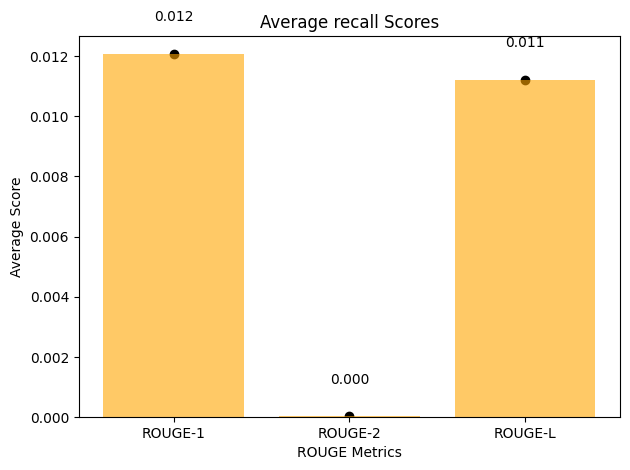

In [26]:
x_values = average_scores.columns
y_values = average_scores.loc['recall']

fig, ax1 = plt.subplots()

ax1.scatter(x_values, y_values, marker='o', color='black')
ax1.set_ylabel('Average Score')
ax1.set_xlabel('ROUGE Metrics')
ax1.set_title('Average recall Scores')

ax1.bar(x_values, y_values, color='orange', alpha=0.6)

for i, v in enumerate(y_values):
    ax1.text(i, v + 0.001, f'{v:.3f}', ha='center', va='bottom', color='black')

plt.tight_layout()

plt.show()

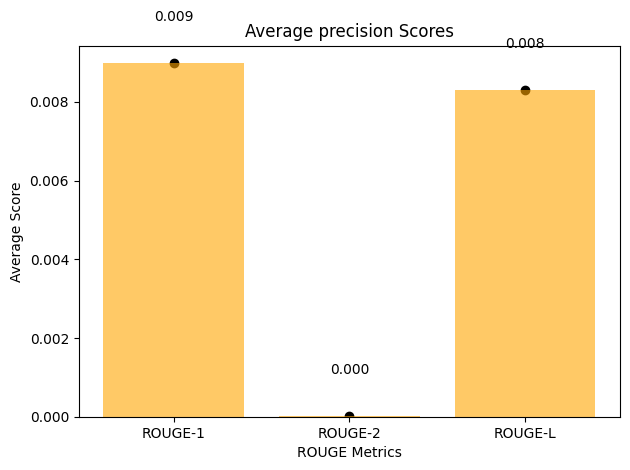

In [27]:
x_values = average_scores.columns
y_values = average_scores.loc['precision']

fig, ax1 = plt.subplots()

ax1.scatter(x_values, y_values, marker='o', color='black')
ax1.set_ylabel('Average Score')
ax1.set_xlabel('ROUGE Metrics')
ax1.set_title('Average precision Scores')

ax1.bar(x_values, y_values, color='orange', alpha=0.6)

for i, v in enumerate(y_values):
    ax1.text(i, v + 0.001, f'{v:.3f}', ha='center', va='bottom', color='black')

plt.tight_layout()

plt.show()

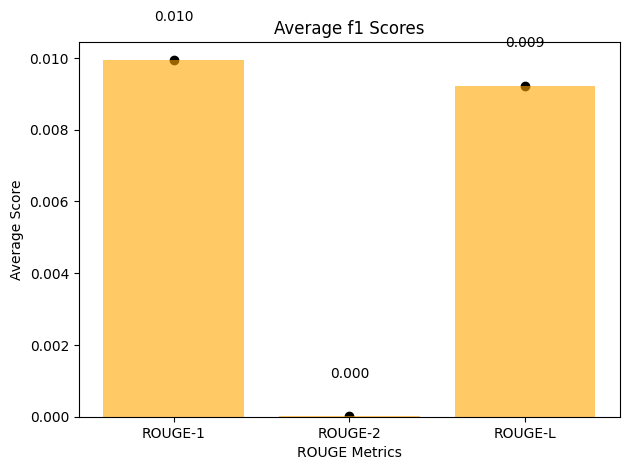

In [28]:
x_values = average_scores.columns
y_values = average_scores.loc['f1-score']

fig, ax1 = plt.subplots()

ax1.scatter(x_values, y_values, marker='o', color='black')
ax1.set_ylabel('Average Score')
ax1.set_xlabel('ROUGE Metrics')
ax1.set_title('Average f1 Scores')

ax1.bar(x_values, y_values, color='orange', alpha=0.6)

for i, v in enumerate(y_values):
    ax1.text(i, v + 0.001, f'{v:.3f}', ha='center', va='bottom', color='black')

plt.tight_layout()

plt.show()

#### Plot Heatmap for ROUGE scores

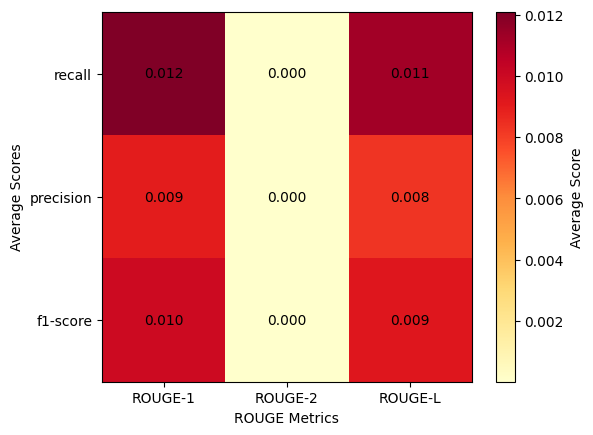

In [29]:
plt.imshow(average_scores, cmap='YlOrRd')

plt.xticks(range(len(average_scores.columns)), average_scores.columns)
plt.yticks(range(len(average_scores.index)), average_scores.index)
plt.xlabel('ROUGE Metrics')
plt.ylabel('Average Scores')

for i in range(len(average_scores.index)):
    for j in range(len(average_scores.columns)):
        plt.text(j, i, f'{average_scores.iloc[i, j]:.3f}', ha='center', va='center', color='black')

plt.colorbar(label='Average Score')

plt.show()